## Setup

The cell below downloads the code from Github and install necessary dependencies.

### Import Packages

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import time
from typing import Any

import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from absl import logging
from matplotlib.colors import ListedColormap
from deeprte.model.engine import RteEngine

from rte_dataset.builders import pipeline

logging.set_verbosity(logging.INFO)

jax.local_devices()

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]

### Utility functions

In [3]:
def rmse(pred, target):
    return np.sqrt(np.mean((pred - target) ** 2) / np.mean(target**2))


def get_normalization_ratio(psi_range, boundary_range):
    psi_range = float(psi_range.split(" ")[-1])
    boundary_range = float(boundary_range.split(" ")[-1])
    return psi_range / boundary_range


def jnp_to_np(output: dict[str, Any]) -> dict[str, Any]:
    """Recursively changes jax arrays to numpy arrays."""
    for k, v in output.items():
        if isinstance(v, dict):
            output[k] = jnp_to_np(v)
        elif isinstance(v, jnp.ndarray):
            output[k] = np.array(v)
    return output


def plot_phi(r, phi_pre, phi_label):
    fig, _axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
    fig.subplots_adjust(hspace=0.3)
    axs = _axs.flatten()

    viridis = matplotlib.colormaps["viridis"](np.linspace(0, 1.2, 128))
    cs_1 = axs[0].contourf(
        r[..., 0], r[..., 1], phi_label, cmap=ListedColormap(viridis)
    )
    axs[0].set_title(r"Exact $f(x,v)$", fontsize=20)
    axs[0].tick_params(axis="both", labelsize=15)
    cbar = fig.colorbar(cs_1)
    cbar.ax.tick_params(labelsize=16)

    cs_2 = axs[1].contourf(r[..., 0], r[..., 1], phi_pre, cmap=ListedColormap(viridis))
    axs[1].set_title(r"Predict $f(x,v)$", fontsize=20)
    axs[1].tick_params(axis="both", labelsize=15)
    cbar = fig.colorbar(cs_2)
    cbar.ax.tick_params(labelsize=16)

    cs_3 = axs[2].contourf(
        r[..., 0],
        r[..., 1],
        abs(phi_pre - phi_label),
        cmap=ListedColormap(viridis),
    )
    axs[2].set_title(r"Absolute error", fontsize=20)
    axs[2].tick_params(axis="both", labelsize=15)
    cbar = fig.colorbar(cs_3)
    cbar.ax.tick_params(labelsize=16)

    plt.tight_layout()

## Load Dataset

In [4]:
# Path to the dataset
DATA_DIR = "/workspaces/deeprte/data/raw_data/test/sin-rv-g0.1-amplitude5-wavenumber10"
DATA_NAME = ["sin-rv-g0.1-amplitude5-wavenumber10.mat"]

data_pipeline = pipeline.DataPipeline(DATA_DIR, DATA_NAME)
raw_feature_dict = data_pipeline.process()
num_examples = raw_feature_dict["shape"]["num_examples"]

del data_pipeline

jax.tree.map(lambda x: x.shape, raw_feature_dict["functions"])

{'boundary': (100, 160, 12),
 'boundary_scattering_kernel': (100, 160, 12, 24),
 'psi_label': (100, 40, 40, 24),
 'scattering_kernel': (100, 40, 40, 24, 24),
 'self_scattering_kernel': (100, 24, 24),
 'sigma': (100, 40, 40, 2)}

## Import Pre-trained model

#### Load model config

In [5]:
from deeprte.model.model import DeepRTEConfig, DeepRTE
from flax import nnx

config = DeepRTEConfig()

In [6]:
model = DeepRTE(config, rngs=nnx.Rngs(0))
nnx.display(model)

In [7]:
from deeprte.configs import default

config = default.get_config("config.yaml")
config.load_parameters_path = ""

config

Config(seed=42, dataset_type='grain', grain_worker_count=0, grain_worker_buffer_size=1, dataset_name='g0.5-sigma_a3-sigma_t6.mat', data_dir='/workspaces/deeprte/data/raw_data/train/g0.5-sigma_a3-sigma_t6', train_split='train[:80%]', eval_split='train[80%:]', enable_data_shuffling=True, data_shuffle_seed=42, per_device_batch_size=1, global_batch_size=8, collocation_size=128, repeat_batch=1, eval_batch_size=4, num_train_steps=500001, micro_steps=2, log_every_steps=1000, eval_every_steps=50000, optimizer='adam', learning_rate=0.001, schedule='cosine_decay', decay_steps=10000, save_checkpoints=True, checkpoint_every_steps=10000, async_checkpointing=True, enable_checkpoint_standard_logger=True, load_parameters_path='', load_full_state_path='', position_coords_dim=2, velocity_coords_dim=2, coeffs_fn_dim=2, num_heads=2, qkv_dim=64, optical_depth_dim=17, num_mlp_layers=4, mlp_dim=128, num_scattering_layers=2, scattering_dim=16, subcollocation_size=128, normalization=0.7472591816503273, mesh_ax

#### Load model parameters

In [8]:
rte_engine = RteEngine(config)

INFO:absl:Devices: [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]
INFO:absl:Number of devices: 4
INFO:absl:Decided on mesh: [[[CudaDevice(id=0)]
  [CudaDevice(id=1)]
  [CudaDevice(id=2)]
  [CudaDevice(id=3)]]]
INFO:absl:Mesh shape: (1, 4, 1)
INFO:absl:No infer checkpoint specified - generating random weights.
INFO:absl:Number of model params=40610


#### Construct model runner

## Predict and Evaluate

#### Predict and Evaluate i-th example in the dataset

#### Run prediction

In [9]:
i = np.random.randint(100)

logging.info("Predicting example %d/%d", i + 1, num_examples)

benchmark = True

feature_dict = {
    "functions": jax.tree.map(lambda x: x[i : i + 1], raw_feature_dict["functions"]),
    "grid": raw_feature_dict["grid"],
    "shape": raw_feature_dict["shape"],
}

# Run the model.
logging.info("Running rte engine...")
processed_feature_dict = rte_engine.process_features(feature_dict)

jax.tree.map(lambda x: x.shape, processed_feature_dict)


t_0 = time.time()
prediction = rte_engine.predict(processed_feature_dict)
t_diff = time.time() - t_0

if benchmark:
    t_0 = time.time()
    rte_engine.predict(processed_feature_dict)
    t_diff = time.time() - t_0
    logging.info(
        "Total JAX model predict time " "(excludes compilation time): %.6fs",
        t_diff,
    )

psi_shape = feature_dict["functions"]["psi_label"].shape
t_0 = time.time()
predicted_psi = prediction.reshape(1, -1).reshape(
    psi_shape
)  # reshape multi_devices to single device

predicted_phi = jnp.sum(
    predicted_psi * feature_dict["grid"]["velocity_weights"],
    axis=-1,
)
t_diff = time.time() - t_0

# Compute metrics.
metrics = {}
psi_label = feature_dict["functions"]["psi_label"]
phi_label = np.sum(psi_label * feature_dict["grid"]["velocity_weights"], axis=-1)
psi_rmse = rmse(predicted_psi, psi_label)
phi_rmse = rmse(predicted_phi, phi_label)
logging.info("RMSE of psi: %f, RMSE of phi: %f\n", psi_rmse, phi_rmse)

INFO:absl:Predicting example 100/100
INFO:absl:Running rte engine...


INFO:absl:Running predict with shape(feat) = {'boundary': (1, 1920), 'boundary_coords': (1, 1920, 4), 'boundary_weights': (1, 1920), 'phase_coords': (1, 38400, 4), 'position_coords': (1, 1600, 2), 'scattering_kernel': (1, 38400, 24), 'self_scattering_kernel': (1, 24, 24), 'sigma': (1, 1600, 2), 'velocity_coords': (1, 24, 2), 'velocity_weights': (1, 24)}
INFO:absl:Output shape was (1, 38400)
INFO:absl:Running predict with shape(feat) = {'boundary': (1, 1920), 'boundary_coords': (1, 1920, 4), 'boundary_weights': (1, 1920), 'phase_coords': (1, 38400, 4), 'position_coords': (1, 1600, 2), 'scattering_kernel': (1, 38400, 24), 'self_scattering_kernel': (1, 24, 24), 'sigma': (1, 1600, 2), 'velocity_coords': (1, 24, 2), 'velocity_weights': (1, 24)}
INFO:absl:Output shape was (1, 38400)
INFO:absl:Total JAX model predict time (excludes compilation time): 2.390390s
INFO:absl:RMSE of psi: 6.147752, RMSE of phi: 7.486144



### Visualize result

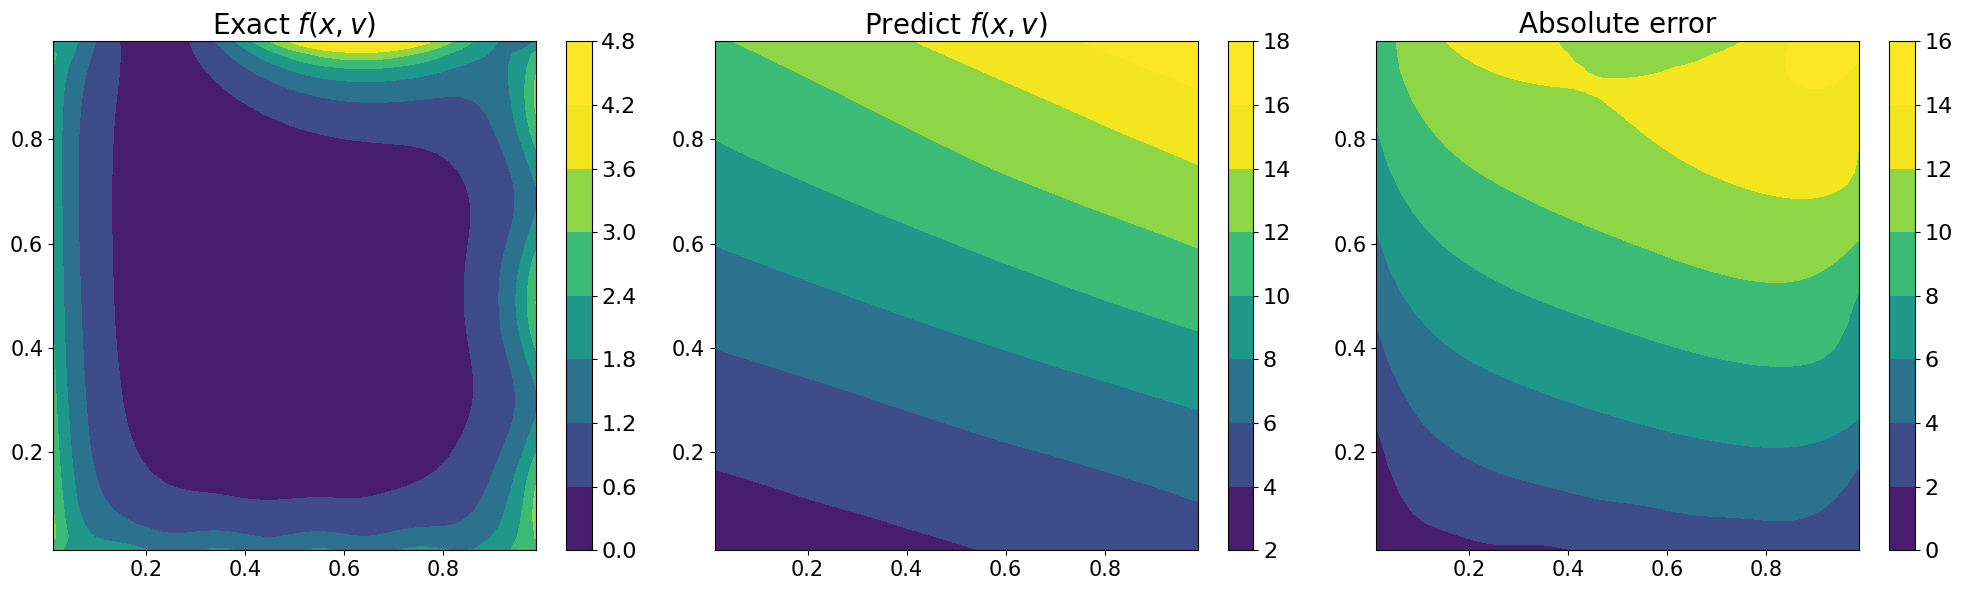

In [10]:
plot_phi(
    feature_dict["grid"]["position_coords"].reshape(*psi_shape[1:-1], -1),
    predicted_phi[0],
    phi_label[0],
)